Here the environment is set to task2 to avoid further corruption.

In [52]:
from pyomo.environ import *
from pyomo.opt import SolverFactory
import matplotlib.pyplot as plt
import numpy as np
import random


In [97]:
# in pyomo there concrete and abstract models. The abstract models are silghtly more tedious to set up,
# and a bit harder to understand in a first contact with Pyomo,
# but then much better for reuse. We use the easy version:
model = ConcreteModel()

#Add some constants to the model
model.N = 50 # number of bugs
model.max_x = 5.0 # width of the box of bugs
model.max_y = 3.0 # length of the box of bugs

# each bug will have x- and y- coordinates, so the lists of all x- resp. y-coordinates
# will each have indices ranging from 0 to N-1.
# This set of indices is part of the model and has to be declared explicitly:
model.indices = range(model.N)

# Add a list of x- and a list of y-coordinates to the model

# We will give them initial values produced by this function:
def random_value(model, i):
    return random.uniform(0,1)
# (we don't need the arguments of this function, but the constructor below wants
# to call a function with two arguments, hence the strange declaration)

# Declare variables of the model:
model.x = Var(model.indices, bounds = (0, None), initialize = random_value)
model.y = Var(model.indices, bounds = (0, None), initialize = random_value)
model.r = Var(bounds = (0, None), initialize = random.uniform(0,1))
# although we only want to model bugs, and those are taken care of by the variables x,y
# it is convenient to add another variable r that act as a lower bound of all bug distances

# for part (b) you should drop a cookie at a random place
# since the cookie doesn't move, you should declare it a parameter, not a variable
# -- otherwise it will be shifted around during optimizing (try it out!)
# this is how it's done:
model.cookie_x = Param(initialize=random.uniform(0,model.max_x))
model.cookie_y = Param(initialize=random.uniform(0,model.max_y))


# Now we build a list of constraints for the variables
model.limits = ConstraintList() # start with the empty list
# add constraints saying that each bug sits inside the box)
for i in model.indices:
    model.limits.add(model.x[i] <= model.max_x)
    model.limits.add(model.y[i] <= model.max_y)
    model.limits.add(model.x[i]*3 <= (model.max_y - model.y[i])*5)


# the above was one way to add constraints, here comes another way:
# We can define constraint functions really as Python functions
# This is super nice and flexible, way more than having to write a closed formula!
def distance_rule(model,i,j):
    if i!=j:
        return (model.x[i]-model.x[j])**2+(model.y[i]-model.y[j])**2 >= model.r**2
    else:
        return Constraint.Skip

model.radius_constraint = Constraint(model.indices, model.indices, rule=distance_rule)

def cookie_distance_rule(model,i):
    cookie_distance = ((model.x[i]-model.cookie_x)**2+(model.y[i]-model.cookie_y)**2)**0.5
    return cookie_distance

# Add an objective to the model:
# This specifies that we want to maximize the variable r of the model
def new_objective(model):
    cookie_distance = sum(cookie_distance_rule(model, i) for i in model.indices)
    # cookie_distance = cookie_distance_rule(model, 0)
    return 17*model.r - cookie_distance/15

model.obj = Objective( rule= new_objective, sense= maximize)

## You could also add the objective in the style of the second constraint we added, i.e.
## define a Python function and then declare that to be the objective. Here is how:
##
## def my_objective(model):
##     bla bla
##
## model.obj = Objective( rule= my_objective, sense= maximize)


# Pyomo has no optimization algorithms in itself
# it uses other libraries, and you have to specify which:
opt = SolverFactory('ipopt')

#here the magic happens:
results=opt.solve(model)
# it can take a while, so better tell when it's done:
print('Done!')


Done!


In [98]:
# ... has the "Done!" been printed yet? If no, wait!


Minimum distance is  0.416


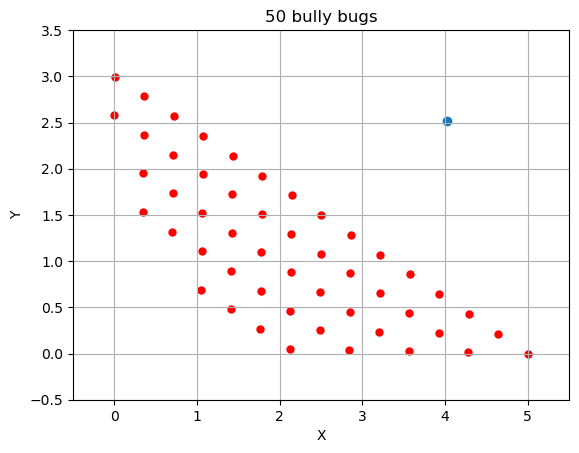

In [99]:
X=[value(model.x[i]) for i in model.indices]
Y=[value(model.y[i]) for i in model.indices]
plt.scatter(X,Y,s=25,color='red')
# plt.scatter(value(model.x[0]), value(model.y[0]))
plt.scatter(model.cookie_x, model.cookie_y)

plt.xlim(-0.5,5.5)
plt.ylim(-.5,3.5)
plt.grid()
plt.xlabel('X')
plt.ylabel('Y')
plt.title(str(value(model.N))+' bully bugs')
print('Minimum distance is ',round(value(model.r),3))
